# Process Conformity Analysis

This notebook analyzes what percentage of structural perturbations (e.g., redo_activity_attack) are valid according to the process model discovered from the full dataset.

The analysis:
1. Discovers a process model (Petri net) from the full event log dataset
2. Loads perturbed prefixes from the structural attack
3. Checks if each prefix is valid according to the process model
4. Calculates the percentage of valid prefixes

In [1]:
import sys
import os
import pandas as pd
import torch

# Add path to import from perturbation_logic
# Notebook is in robustness/perturbator/, module is in robustness/perturbator/perturbation_logic/
perturbation_logic_path = os.path.join(os.getcwd(), 'perturbation_logic')
if os.path.exists(perturbation_logic_path):
    sys.path.insert(0, perturbation_logic_path)
else:
    # Try alternative path if running from different directory
    perturbation_logic_path = 'perturbation_logic'
    if os.path.exists(perturbation_logic_path):
        sys.path.insert(0, perturbation_logic_path)

from petri_net_replay_markings import InductiveMiner, is_prefix_valid

print("Imports successful!")

Imports successful!


## Step 1: Discover Process Model from Full Dataset

Load the full helpdesk dataset and discover a Petri net process model using Inductive Miner.

In [ ]:
# Path to the full dataset
dataset_path = '../../data/helpdesk.csv'

# Initialize InductiveMiner with helpdesk column names
miner = InductiveMiner(
    path_to_csv_log=dataset_path,
    case_id_col="Case ID",
    activity_col="Activity",
    timestamp_col="Complete Timestamp",
    resource_col="Resource"
)

# Discover Petri net model
print("Discovering process model from full dataset...")
net, initial_marking, final_marking = miner.discover_petri_net(visulaize=False)

print(f"Process model discovered successfully!")
print(f"Number of places: {len(net.places)}")
print(f"Number of transitions: {len(net.transitions)}")

Discovering process model from full dataset...
Process model discovered successfully!
Number of places: 31
Number of transitions: 51


### Visualize the Discovered Petri Net

Visualize the process model to understand its structure.

Generating Petri net visualization...


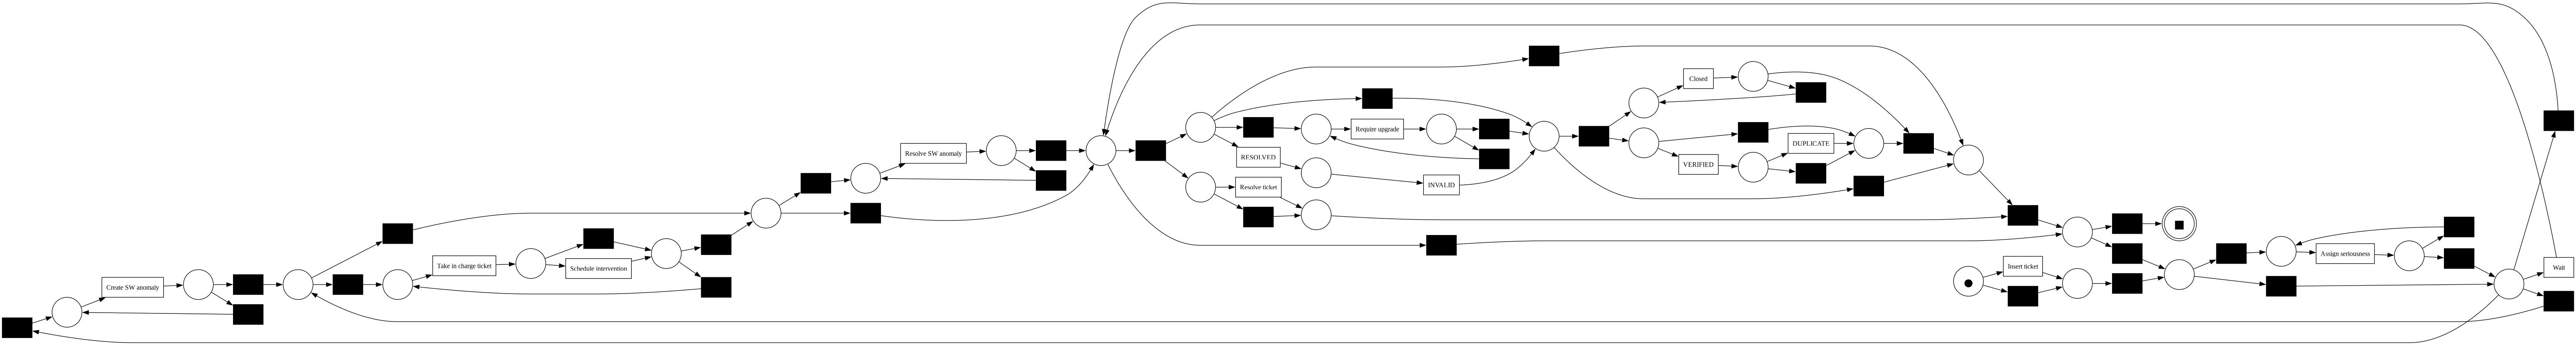

Visualization displayed!


In [ ]:
from pm4py.visualization.petri_net import visualizer as pn_visualizer
from IPython.display import Image, display
import tempfile
import os

# Visualize the Petri net
print("Generating Petri net visualization...")
gviz = pn_visualizer.apply(net, initial_marking, final_marking)

# Option 1: View in separate window (uncomment to use)
# pn_visualizer.view(gviz)

# Option 2: Save and display inline in notebook
temp_file = tempfile.NamedTemporaryFile(delete=False, suffix='.png')
temp_path = temp_file.name
temp_file.close()

try:
    pn_visualizer.save(gviz, temp_path)
    print(f"Petri net saved to temporary file")
    
    # Display inline
    display(Image(temp_path))
    
    # Optionally save to a permanent location
    # pn_visualizer.save(gviz, "helpdesk_petri_net.png")
    # print("Also saved to: helpdesk_petri_net.png")
    
finally:
    # Clean up temp file after a delay (or keep it for inspection)
    # os.unlink(temp_path)  # Uncomment to delete temp file immediately
    pass

## Step 2: Load Perturbed Dataset

Load the perturbed dataset containing prefixes and suffixes from the structural attack.

In [3]:
# Path to perturbed dataset
perturbed_path = '../../perturbed_data/helpdesk/redo_pert.pkl'

print(f"Loading perturbed dataset from: {perturbed_path}")
perturbed_data = torch.load(perturbed_path, weights_only=False)

print(f"Loaded {len(perturbed_data)} perturbed prefix-suffix pairs")
print(f"Sample keys: {list(perturbed_data.keys())[:5]}")

Loading perturbed dataset from: ../../perturbed_data/helpdesk/redo_pert.pkl
Loaded 1898 perturbed prefix-suffix pairs
Sample keys: [('Case 1', 1), ('Case 1', 2), ('Case 1', 3), ('Case 10', 1), ('Case 10', 2)]


## Step 3: Check Validity of Each Prefix

For each prefix in the perturbed dataset, extract the activity sequence and check if it's valid according to the process model.

In [4]:
# Activity column name (used in DataFrames)
activity_column = "Activity"

# Track validity
valid_count = 0
invalid_count = 0
total_count = 0
valid_prefixes = []
invalid_prefixes = []

print("Checking validity of prefixes...")
print("=" * 80)

for (case_id, prefix_length), prefix_suffix_pair in perturbed_data.items():
    total_count += 1
    
    # Handle both formats: [prefix, suffix] or (prefix_df, suffix_df)
    if isinstance(prefix_suffix_pair, (list, tuple)) and len(prefix_suffix_pair) >= 2:
        prefix_data = prefix_suffix_pair[0]
    else:
        prefix_data = prefix_suffix_pair
    
    # Extract activity sequence from prefix
    # Handle both DataFrame and list formats
    if isinstance(prefix_data, pd.DataFrame):
        # Filter out EOS rows if present
        prefix_df = prefix_data[prefix_data[activity_column] != "EOS"]
        if len(prefix_df) == 0:
            # If all are EOS, use the original DataFrame
            prefix_df = prefix_data
        prefix_activities = prefix_df[activity_column].tolist()
    elif isinstance(prefix_data, list):
        # If it's already a list of activities
        prefix_activities = [act for act in prefix_data if act != "EOS"]
        if len(prefix_activities) == 0:
            prefix_activities = prefix_data
    else:
        print(f"Warning: Unknown prefix format for case {case_id}, prefix_length {prefix_length}")
        invalid_count += 1
        invalid_prefixes.append((case_id, prefix_length))
        continue
    
    # Check validity using token replay
    try:
        is_valid = is_prefix_valid(prefix_activities, net, initial_marking, final_marking)
        
        if is_valid:
            valid_count += 1
            valid_prefixes.append((case_id, prefix_length))
        else:
            invalid_count += 1
            invalid_prefixes.append((case_id, prefix_length))
    except Exception as e:
        print(f"Error checking validity for case {case_id}, prefix_length {prefix_length}: {e}")
        invalid_count += 1
        invalid_prefixes.append((case_id, prefix_length))
    
    # Progress update every 100 cases
    if total_count % 100 == 0:
        print(f"Processed {total_count} prefixes... (Valid: {valid_count}, Invalid: {invalid_count})")

print("=" * 80)
print(f"Completed checking {total_count} prefixes")

Checking validity of prefixes...
Processed 100 prefixes... (Valid: 98, Invalid: 2)
Processed 200 prefixes... (Valid: 198, Invalid: 2)
Processed 300 prefixes... (Valid: 296, Invalid: 4)
Processed 400 prefixes... (Valid: 396, Invalid: 4)
Processed 500 prefixes... (Valid: 495, Invalid: 5)
Processed 600 prefixes... (Valid: 595, Invalid: 5)
Processed 700 prefixes... (Valid: 695, Invalid: 5)
Processed 800 prefixes... (Valid: 794, Invalid: 6)
Processed 900 prefixes... (Valid: 892, Invalid: 8)
Processed 1000 prefixes... (Valid: 991, Invalid: 9)
Processed 1100 prefixes... (Valid: 1087, Invalid: 13)
Processed 1200 prefixes... (Valid: 1185, Invalid: 15)
Processed 1300 prefixes... (Valid: 1283, Invalid: 17)
Processed 1400 prefixes... (Valid: 1383, Invalid: 17)
Processed 1500 prefixes... (Valid: 1483, Invalid: 17)
Processed 1600 prefixes... (Valid: 1581, Invalid: 19)
Processed 1700 prefixes... (Valid: 1681, Invalid: 19)
Processed 1800 prefixes... (Valid: 1780, Invalid: 20)
Completed checking 1898 p

## Step 4: Calculate and Display Results

Calculate the percentage of valid prefixes and display summary statistics.

In [6]:
# Calculate percentage
if total_count > 0:
    percent_valid = (valid_count / total_count) * 100
    percent_invalid = (invalid_count / total_count) * 100
else:
    percent_valid = 0
    percent_invalid = 0

# Display results
print("=" * 80)
print("PROCESS CONFORMITY ANALYSIS RESULTS")
print("=" * 80)
print(f"\nTotal prefixes analyzed: {total_count}")
print(f"Valid prefixes: {valid_count} ({percent_valid:.2f}%)")
print(f"Invalid prefixes: {invalid_count} ({percent_invalid:.2f}%)")
print("=" * 80)

# Additional statistics
if total_count > 0:
    print(f"\nSummary:")
    print(f"  - Validity rate: {percent_valid:.2f}%")
    print(f"  - Invalid rate: {percent_invalid:.2f}%")
    
    # Helper function to extract activities from prefix data
    def extract_activities(case_id, prefix_len):
        """Extract activity sequence from prefix data."""
        if (case_id, prefix_len) not in perturbed_data:
            return []
        
        prefix_data = perturbed_data[(case_id, prefix_len)]
        if isinstance(prefix_data, (list, tuple)) and len(prefix_data) >= 1:
            prefix_data = prefix_data[0]
        
        if isinstance(prefix_data, pd.DataFrame):
            activities = prefix_data[prefix_data[activity_column] != "EOS"][activity_column].tolist()
        elif isinstance(prefix_data, list):
            activities = [a for a in prefix_data if a != "EOS"]
        else:
            activities = []
        
        return activities
    
    # Show 50 valid prefixes
    print(f"\n{'=' * 80}")
    print(f"VALID PREFIXES (showing up to 50):")
    print(f"{'=' * 80}")
    num_valid_to_show = min(50, len(valid_prefixes))
    for i, (case_id, prefix_len) in enumerate(valid_prefixes[:num_valid_to_show]):
        activities = extract_activities(case_id, prefix_len)
        print(f"  {i+1}. Case: {case_id}, Prefix Length: {prefix_len}, Activities: {activities}")
    
    if len(valid_prefixes) > 50:
        print(f"\n  ... and {len(valid_prefixes) - 50} more valid prefixes")
    
    # Show 50 invalid prefixes
    print(f"\n{'=' * 80}")
    print(f"INVALID PREFIXES (showing up to 50):")
    print(f"{'=' * 80}")
    num_invalid_to_show = min(50, len(invalid_prefixes))
    for i, (case_id, prefix_len) in enumerate(invalid_prefixes[:num_invalid_to_show]):
        activities = extract_activities(case_id, prefix_len)
        print(f"  {i+1}. Case: {case_id}, Prefix Length: {prefix_len}, Activities: {activities}")
    
    if len(invalid_prefixes) > 50:
        print(f"\n  ... and {len(invalid_prefixes) - 50} more invalid prefixes")

PROCESS CONFORMITY ANALYSIS RESULTS

Total prefixes analyzed: 1898
Valid prefixes: 1878 (98.95%)
Invalid prefixes: 20 (1.05%)

Summary:
  - Validity rate: 98.95%
  - Invalid rate: 1.05%

VALID PREFIXES (showing up to 50):
  1. Case: Case 1, Prefix Length: 1, Activities: ['Assign seriousness', 'Assign seriousness']
  2. Case: Case 1, Prefix Length: 2, Activities: ['Assign seriousness', 'Take in charge ticket', 'Take in charge ticket']
  3. Case: Case 1, Prefix Length: 3, Activities: ['Assign seriousness', 'Take in charge ticket', 'Take in charge ticket', 'Take in charge ticket']
  4. Case: Case 10, Prefix Length: 1, Activities: ['Assign seriousness', 'Assign seriousness']
  5. Case: Case 10, Prefix Length: 2, Activities: ['Assign seriousness', 'Take in charge ticket', 'Take in charge ticket']
  6. Case: Case 100, Prefix Length: 1, Activities: ['Assign seriousness', 'Assign seriousness']
  7. Case: Case 100, Prefix Length: 2, Activities: ['Assign seriousness', 'Take in charge ticket', 'T